### Week 7: Tuning and Ensemble learning

Instructor: Cornelia Ilin <br>
Email: cilin@ischool.berkeley.edu <br>

Citations: <br>
 - Chapter 6, 7: Python Machine Learning 3rd Edition by [Sebastian Raschka](https://sebastianraschka.com), Packt Publishing Ltd. 2019

---
##### <span style="color:chocolate">Question 1</span>: What methods can we use to build a good classifier by fine-tuning its hyperparameters? Select from below.
 - prediction error
 - k-fold cross-validation
 - confusion matrix
 - grid search
 - accuracy
 - holdout method

##### <span style="color:chocolate">Question 2</span>: What is the difference between the holdout method and K-fold cross-validation?

##### <span style="color:chocolate">Question 3</span>: What methods can we use to construct a set of classifiers that can often have better performance than any of its individual members?
- majority vote
- k-fold cross-validation
- bagging
- adaptive boosting (AdaBoost)
- holdout method

---
#### ``Objectives`` 
 - holdout method and K-fold validation.
 - make predictions based on majority voting.
 - use bagging to reduce overfitting.
 - use boosting to build powerful models from weak learners that learn from their mistakes.

---
### Holdout method
   - In ML we are also interested to see how the model predictions change as we change the value of hyperparameters (a.k.a., tuning parameters)
   - the idea is to separate the data into 3 parts: training set, validation set, test set.

Main steps:
 1.  repeatedly train on the train dataset using different hyperparameter values
 2.  test the performance on the validation set and choose the hyperparameter values that lead to best predictions
 3.  once you find the hyperparameter values that satisfy you, estimate the model's generalization performance on the test dataset.

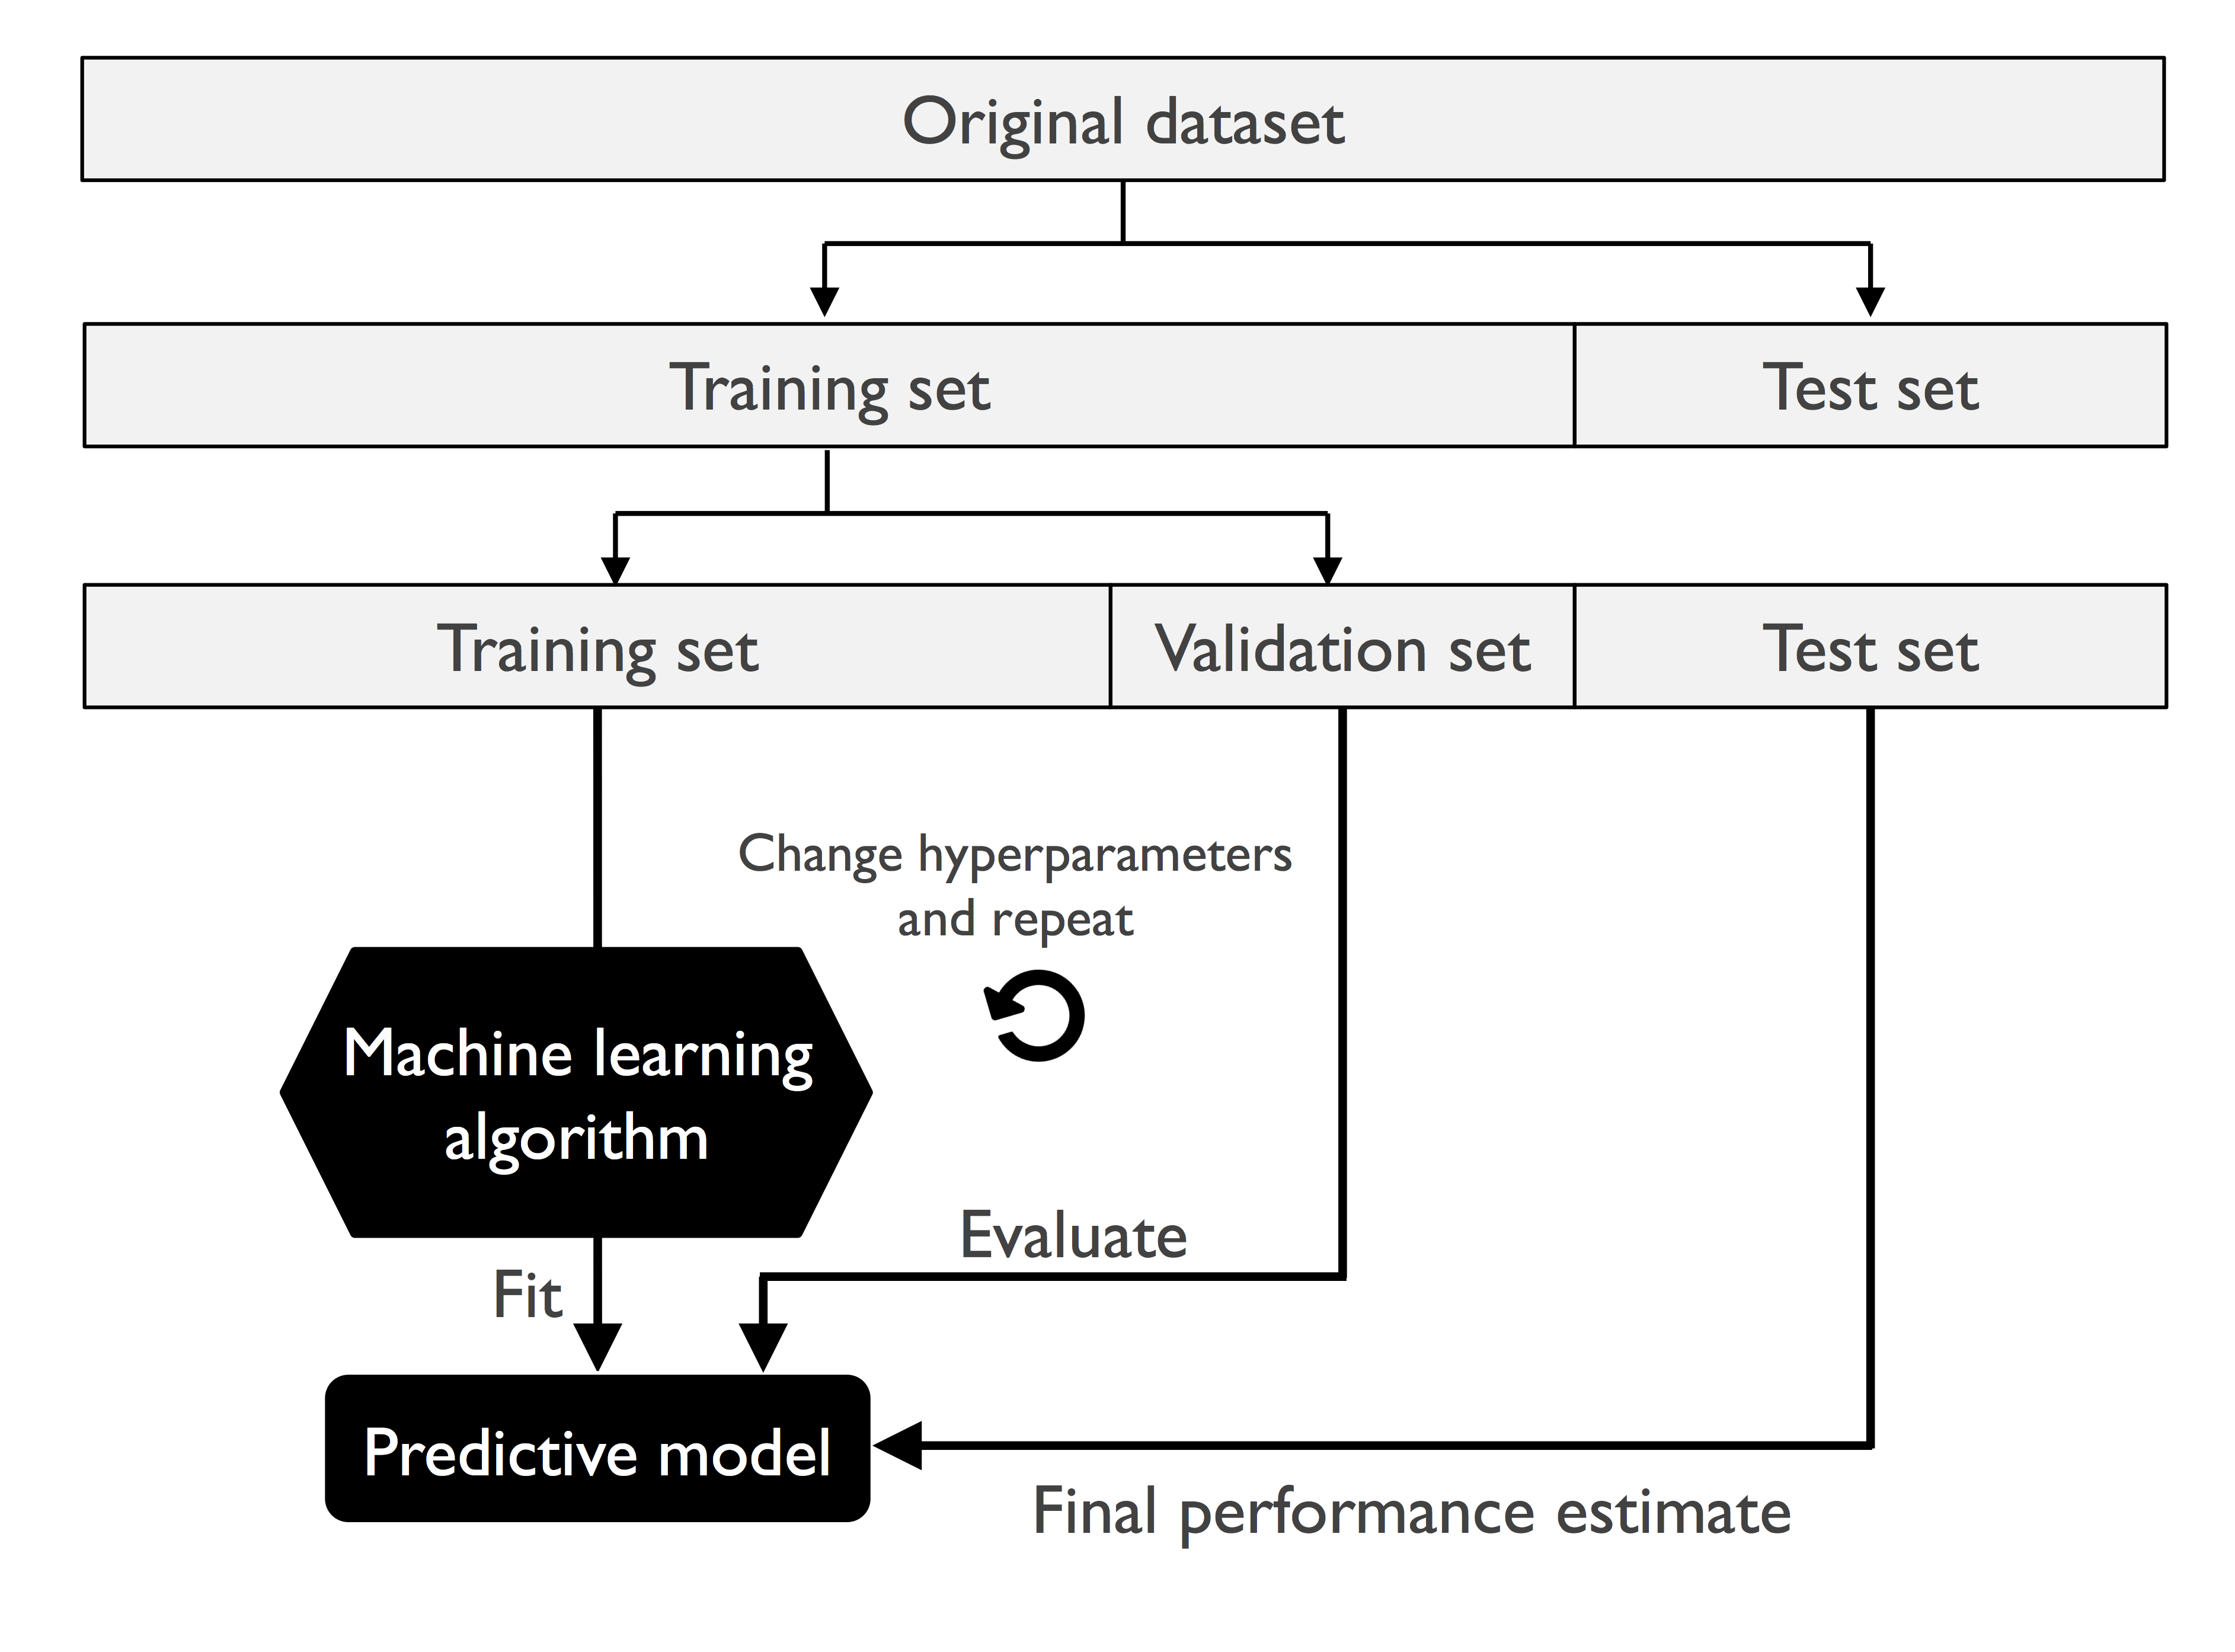

In [1]:
# The figure bellow illustrates the concepts of the holdout method
from IPython.display import Image
Image(filename='./images/06_02.png', width=400)

The disadvantage of this method is that the 'best' hyperparamter values may be very sensitive to how we partition the training and validation sets. 

To overcome this issue we can use K-fold validation, where we repeat the holdout method K-times on K subsets of the training data.

---
### K-fold validation
- randomly splits the training data into K folds w/o replacement.
- use K-1 folds for training, and 1 fold for validation.
- repeat procedure K times, to obtain K models and performance estimates. 
- empirical evidence suggests that the most optimal value for K is 10.

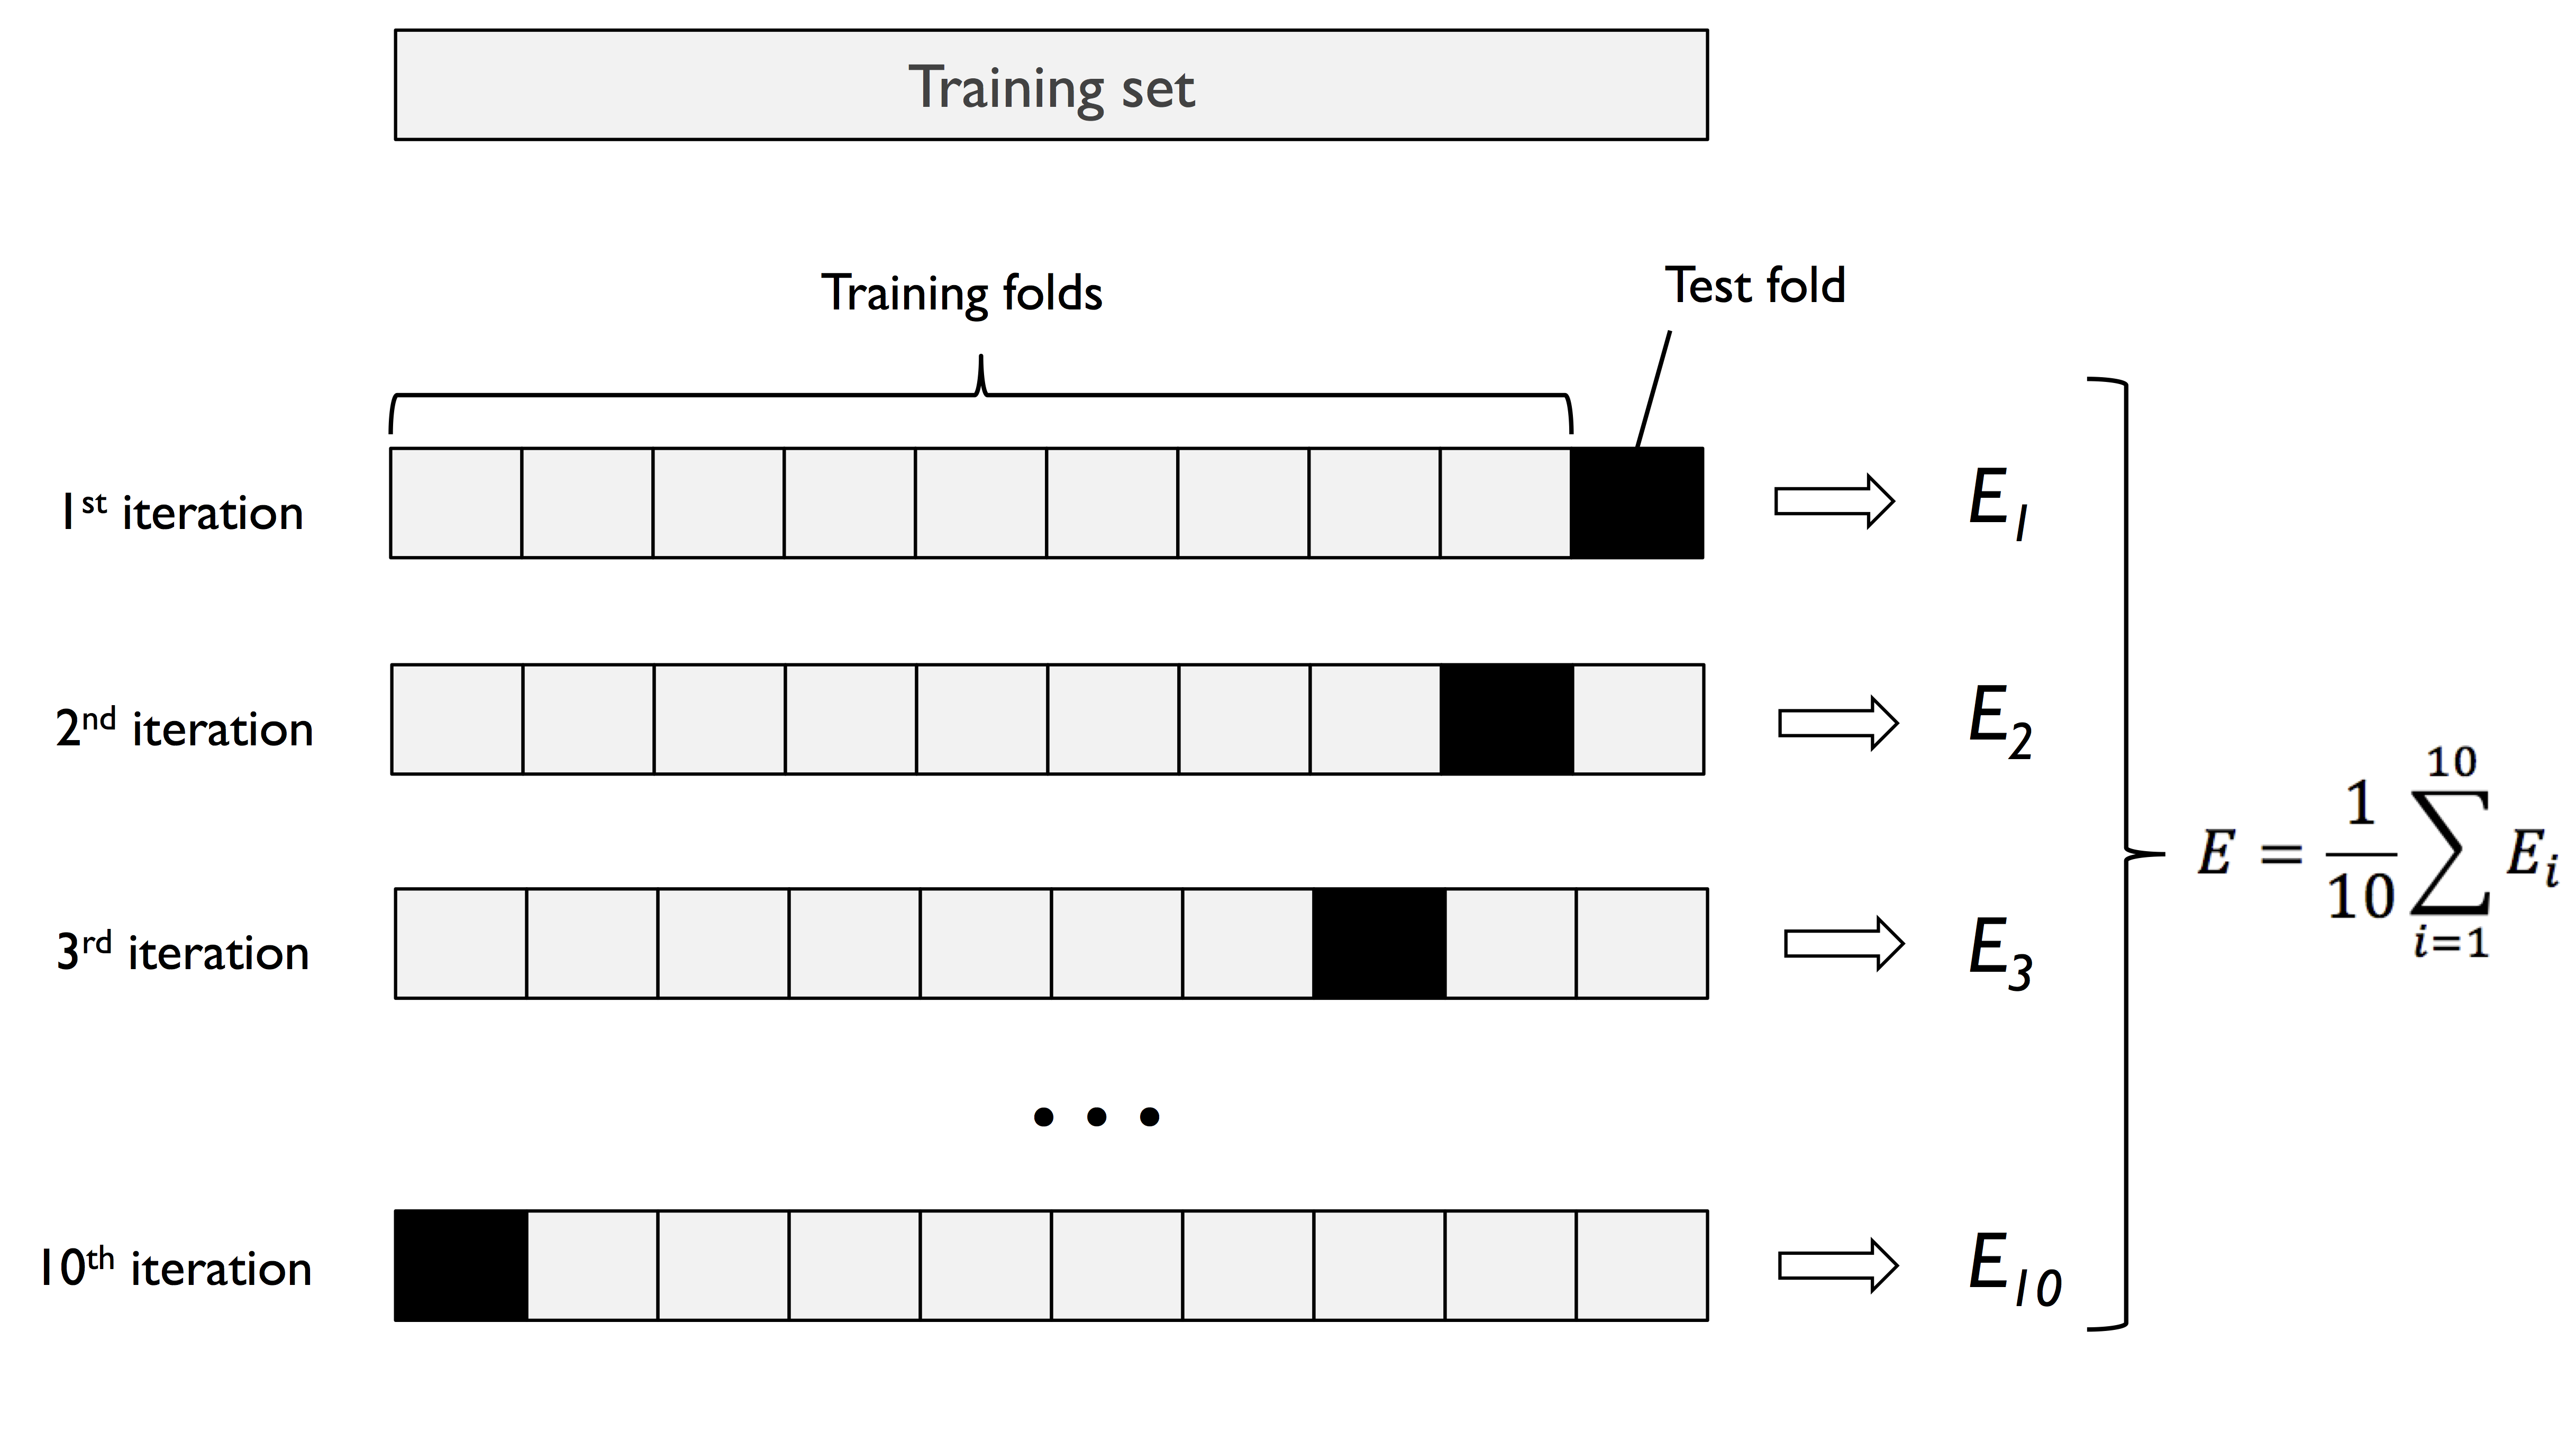

In [2]:
# The figure bellow illustrates the concepts of K-fold validation
Image(filename='./images/06_03.png', width=500)

---
### Learning with ensembles
 - the idea is to combine different classifiers into a super-classifier whose performance is much better than using each individual classifier alone.
 - assume that you collect predictions from 10 expert classifiers (e.g., KNN, NB, ...). ensemble methods will allow us to combine their individual predictions to come up with a final prediction that is more accurate and robust.
 - 3 most commonly used ensembles: majority vote, bagging, and boosting.

##### <span style="color:chocolate">The majority vote principle</span>
 - selects the class label that has been predicted by the majority of classifiers (i.e., received more than 50 percent of votes).
 - the term majority vote is used for a binary class setting.
 - plurality vote is used for a multiclass setting.

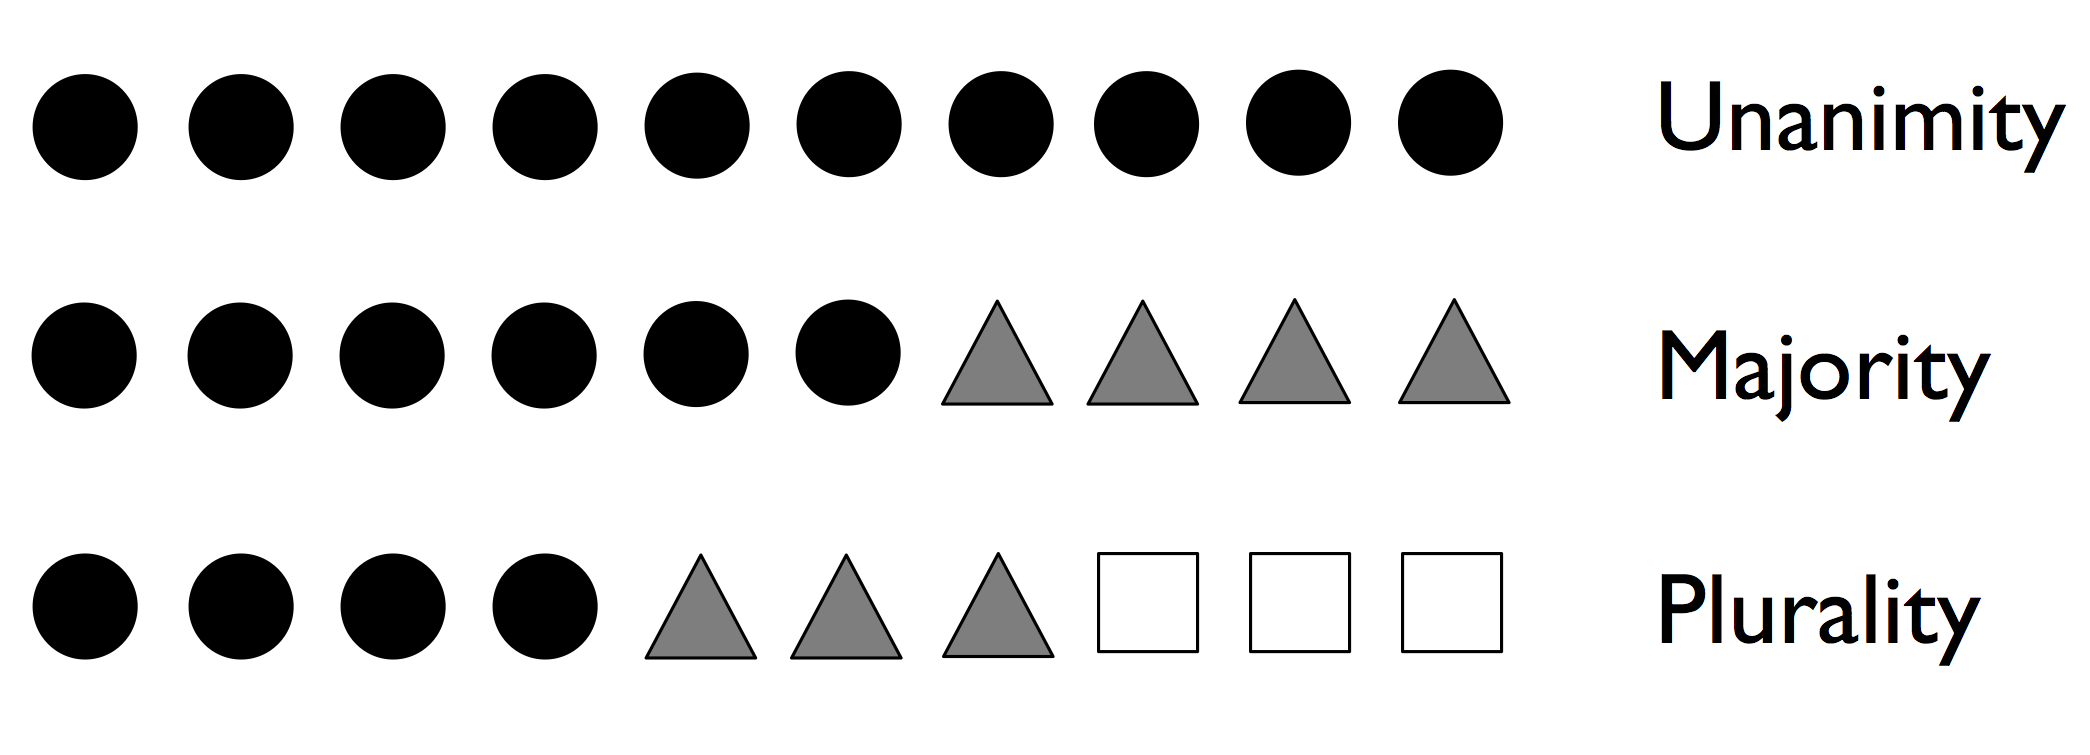

In [3]:
# The figure bellow illustrates the concepts of majority and plurality for an ansamble of 10 classifiers (a triangle, square, circle, represent a unique class label).
Image(filename='./images/07_01.png', width=400)

##### <span style="color:chocolate">The bagging principle</span>
 - it's closely related to the majority vote technique.
 - the difference is that instead of using the same training data to fit the different classifiers in the ensemble, we draw bootstrap (random) samples w/ replacement from the initial training data.

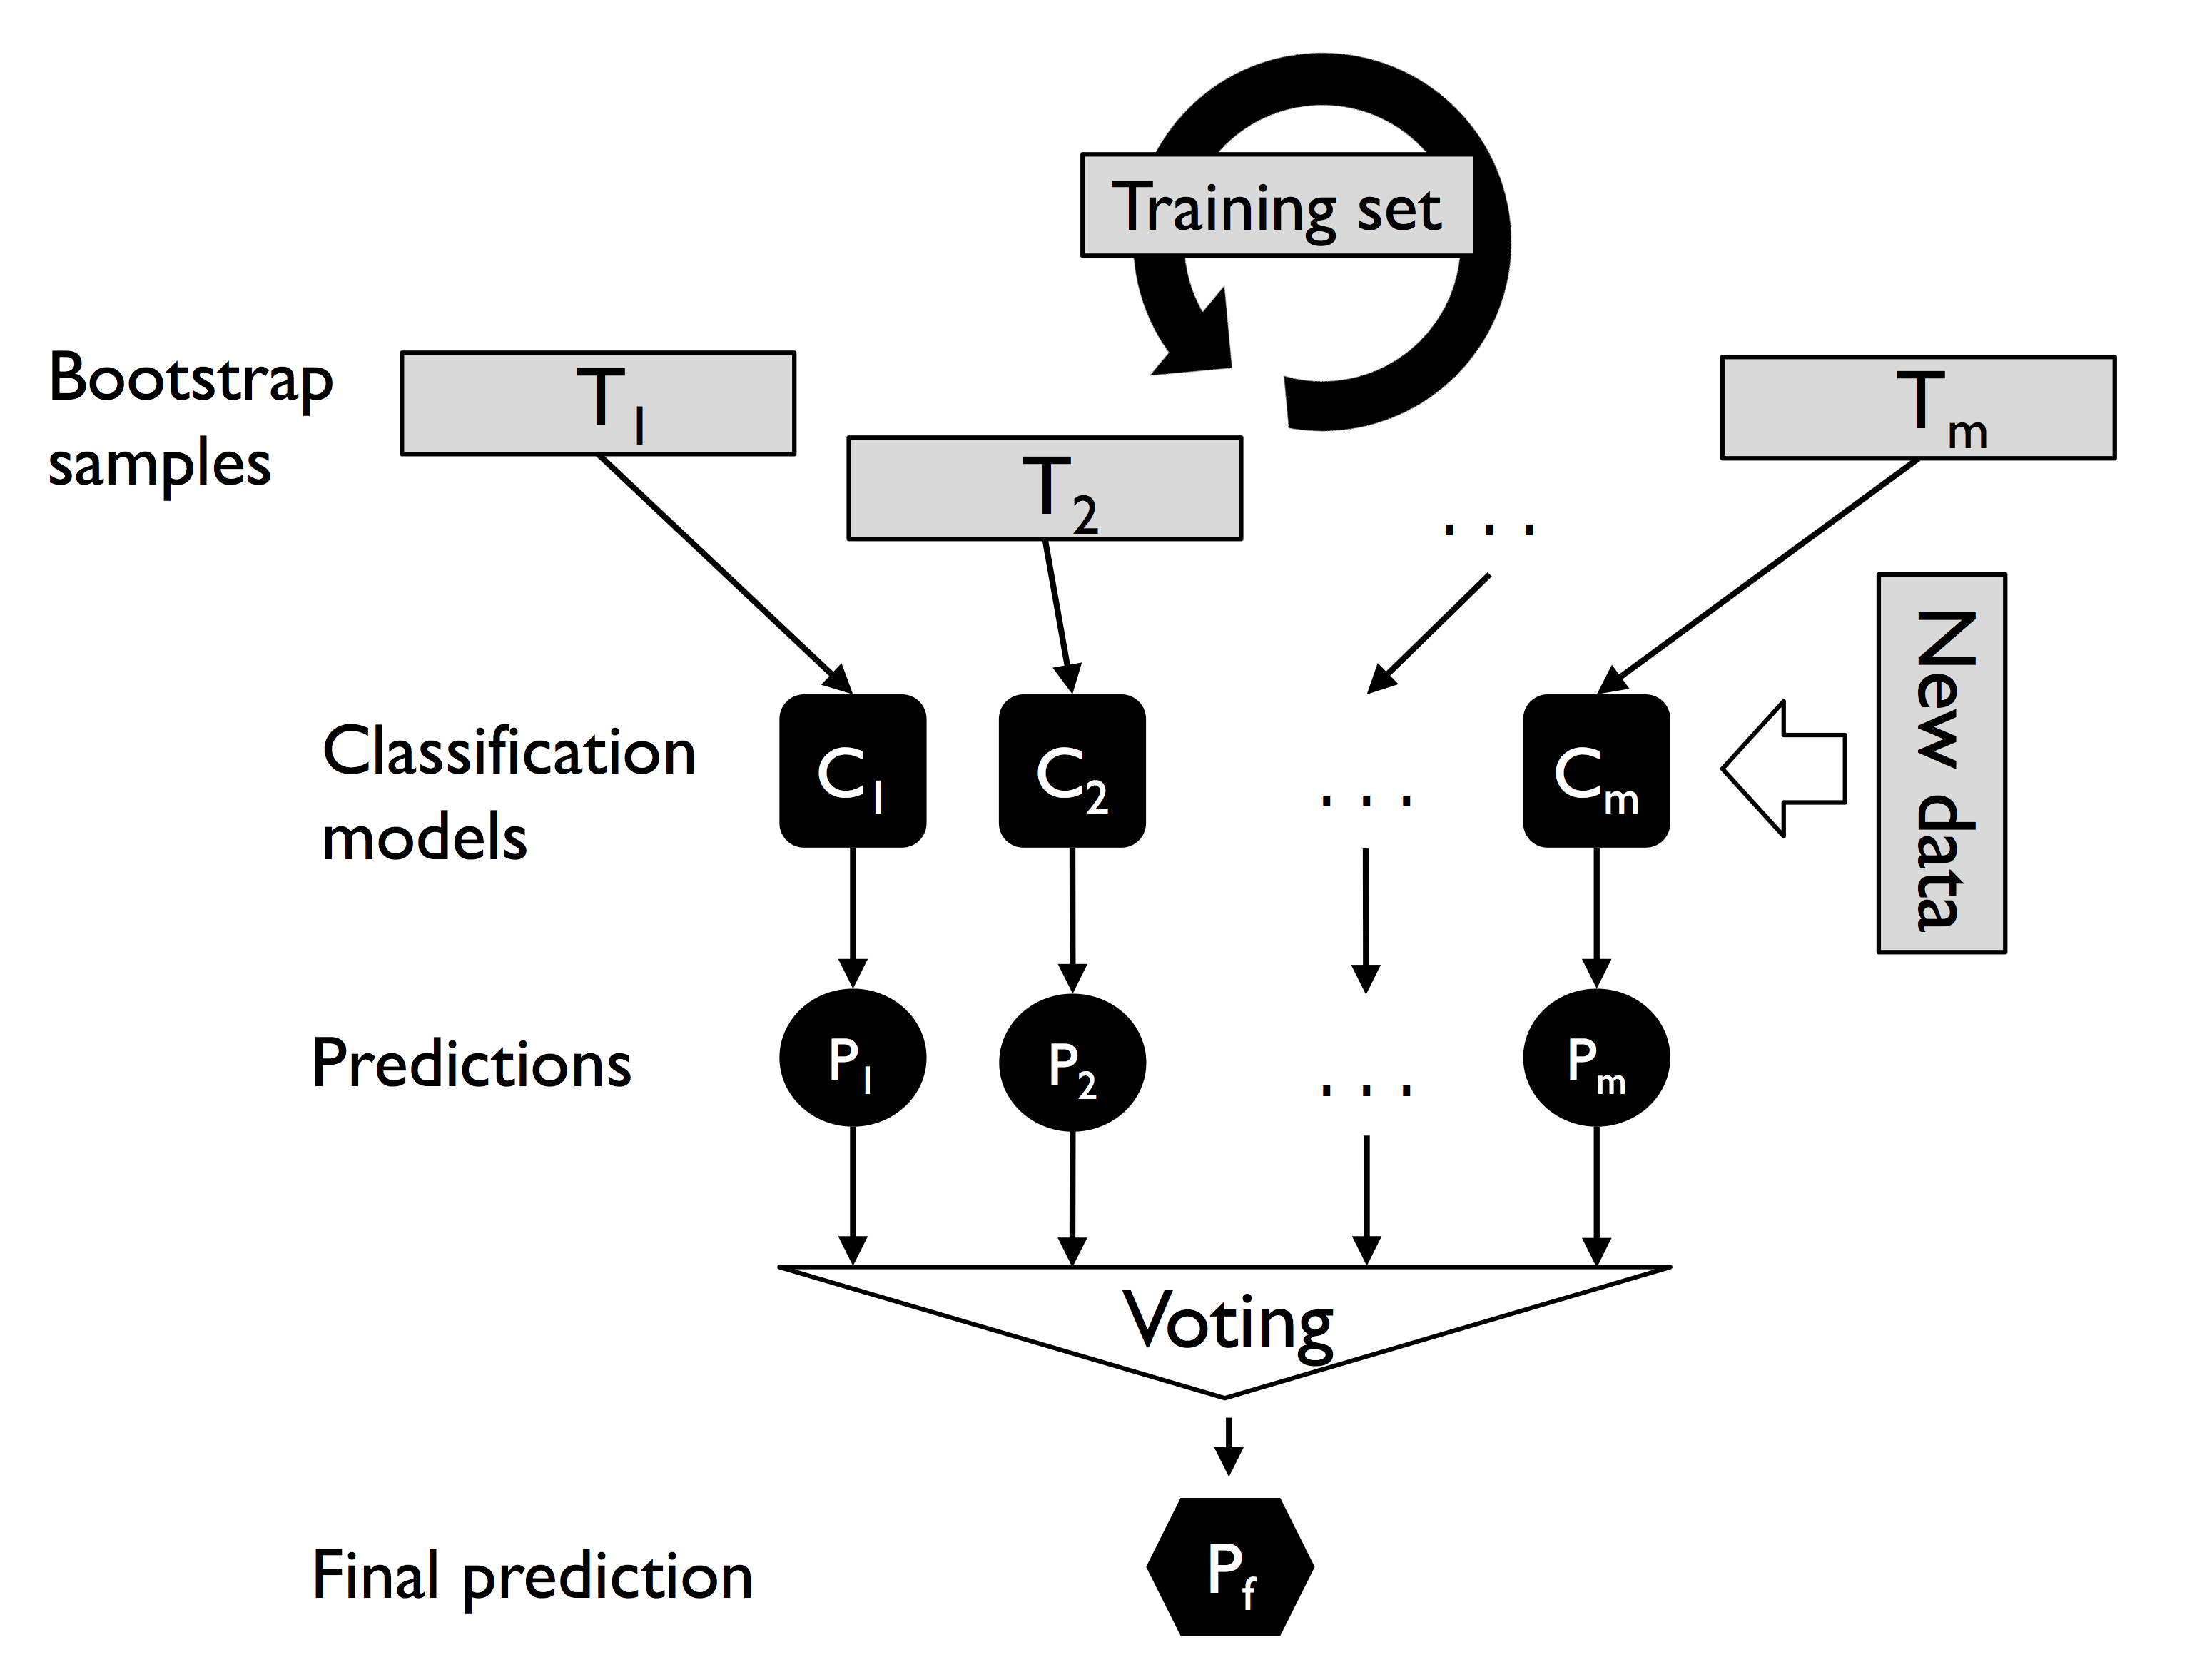

In [4]:
# The figure bellow illustrates the concept of boosting
Image(filename='./images/07_06.png', width=400)

##### <span style="color:chocolate">The adaptive boosting (AdaBoost) principle</span>
- the ensemble consists of very simple base classifiers (weak learners; think decision tree stump).
- focuses on training examples that are hard to clasify, i.e.,
- let the weak learners learn from their mistakes (misclassified training examples) to improve the performance of the ensemble.
- in contrast to bagging, the boosting algorithm uses random subsets of training examples drawn from the training dataset without replacement.

---
### Step 1: Import packages

In [5]:
# standard libraries
import pandas as pd
import numpy as np
import operator

# visualizations
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline

# pipelines
from sklearn.pipeline import _name_estimators
from sklearn.pipeline import Pipeline

# data preprocessing, cross-validation, accuracies
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

# individual classifiers
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier 

# ensemble classifiers
##(not that we use a user defined class for MajorityVoting)
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier

# others
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.base import clone

### Step 2: Define working directories

### Step 3: Define classes

In [6]:
class MajorityVoteClassifier(BaseEstimator, 
                             ClassifierMixin):
    """ A majority vote ensemble classifier

    Parameters
    ----------
    classifiers : array-like, shape = [n_classifiers]
      Different classifiers for the ensemble

    vote : str, {'classlabel', 'probability'} (default='classlabel')
      If 'classlabel' the prediction is based on the argmax of
        class labels. Else if 'probability', the argmax of
        the sum of probabilities is used to predict the class label
        (recommended for calibrated classifiers).

    weights : array-like, shape = [n_classifiers], optional (default=None)
      If a list of `int` or `float` values are provided, the classifiers
      are weighted by importance; Uses uniform weights if `weights=None`.

    """
    def __init__(self, classifiers, vote='classlabel', weights=None):

        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value
                                  in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights

    def fit(self, X, y):
        """ Fit classifiers.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_examples, n_features]
            Matrix of training examples.

        y : array-like, shape = [n_examples]
            Vector of target class labels.

        Returns
        -------
        self : object

        """
        if self.vote not in ('probability', 'classlabel'):
            raise ValueError("vote must be 'probability' or 'classlabel'"
                             "; got (vote=%r)"
                             % self.vote)

        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError('Number of classifiers and weights must be equal'
                             '; got %d weights, %d classifiers'
                             % (len(self.weights), len(self.classifiers)))

        # Use LabelEncoder to ensure class labels start with 0, which
        # is important for np.argmax call in self.predict
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self

    def predict(self, X):
        """ Predict class labels for X.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_examples, n_features]
            Matrix of training examples.

        Returns
        ----------
        maj_vote : array-like, shape = [n_examples]
            Predicted class labels.
            
        """
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:  # 'classlabel' vote

            #  Collect results from clf.predict calls
            predictions = np.asarray([clf.predict(X)
                                      for clf in self.classifiers_]).T

            maj_vote = np.apply_along_axis(
                                      lambda x:
                                      np.argmax(np.bincount(x,
                                                weights=self.weights)),
                                      axis=1,
                                      arr=predictions)
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote

    def predict_proba(self, X):
        """ Predict class probabilities for X.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_examples, n_features]
            Training vectors, where n_examples is the number of examples and
            n_features is the number of features.

        Returns
        ----------
        avg_proba : array-like, shape = [n_examples, n_classes]
            Weighted average probability for each class per example.

        """
        probas = np.asarray([clf.predict_proba(X)
                             for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba

    def get_params(self, deep=True):
        """ Get classifier parameter names for GridSearch"""
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in self.named_classifiers.items():
                for key, value in step.get_params(deep=True).items():
                    out['%s__%s' % (name, key)] = value
            return out


### Step 4: Define functions

---
### Step 5: Read data
---

In [7]:
df_init = pd.read_csv('https://archive.ics.uci.edu/'
                      'ml/machine-learning-databases/wine/wine.data',
                      header=None)

df_init.columns = ['class_label', 'alcohol', 'malic_acid', 'ash',
              'alcalinity_of_ash', 'magnesium', 'total_pphenols',
              'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins',
              'color_intensity', 'hue', 'OD280/OD315_of_diluted_wines',
              'proline']

print('Shape of df wine:', df_init.shape)
print('Class labels:', df_init['class_label'].unique())
print()
df_init.head()

Shape of df wine: (178, 14)
Class labels: [1 2 3]



,class_label,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_pphenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,OD280/OD315_of_diluted_wines,proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


---
### Step 6: Data preprocessing
---

#### Step 6.1 Recode class labels

easier to iterate functions that iterate through labels (index starts at 0 in Python)

In [8]:
class_mapping = {label: idx for idx, label in enumerate(np.unique(df_init.class_label))}
class_mapping

df_init['class_label'] = df_init.class_label.map(class_mapping)
print('Class labels:', df_init.class_label.unique())

Class labels: [0 1 2]


#### Step 6.2 Data subseting

Today we will only be working with class labels 0 and 1 (I want to focus on a majority vote example, so the outcome should be binary), and three features ['alcohol', 'ash', 'malic_acid](this will make the classification task more challenging).

In [9]:
# select only labels 0 and 1
df = df_init[df_init.class_label !=2]

# select only 4 features
labels = ['class_label']
features = ['alcohol', 'OD280/OD315_of_diluted_wines']
df = df[labels+features]
print('Class labels:', df.class_label.unique())
df.head()

Class labels: [0 1]


,class_label,alcohol,OD280/OD315_of_diluted_wines
0,0,14.23,3.92
1,0,13.20,3.40
2,0,13.16,3.17
3,0,14.37,3.45
4,0,13.24,2.93


#### Step 6.3 Split data into train and test sets

In [10]:
# note that I only crate training and test sets (so no validation set) because I do not plan to do hyperparameter tuning.

# create X and y arrays
X = np.array(df.iloc[:, 1:])
y = np.array(df.iloc[:, 0])


# create samples
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,
                                                    random_state=1, stratify=y)

In [11]:
print('Shape X_train: ', X_train.shape, '\nShape X_test: ', X_test.shape,
      '\nShape y_train: ', y_train.shape, '\nShape y_test:', y_test.shape)

Shape X_train:  (104, 2) 
Shape X_test:  (26, 2) 
Shape y_train:  (104,) 
Shape y_test: (26,)


---
### Step 7: Ensemble learning - majority vote
---

#### Step 7.1: Train two different classifiers (Decision tree and KNN) using the training dataset.

In [12]:
clf1 = DecisionTreeClassifier(max_depth=2,
                              criterion='entropy')

clf2 = KNeighborsClassifier(n_neighbors=5,
                            p=2,
                            metric='minkowski')

# the KNN classifier is not scale-invariant whereas the decission tree classifier is. 
# remember it's a good habit to work with standardized features, so let's use a Pipeline to standardize the features for KNN
# the StandardScaller method in sklearn.preprocessing module does this for us
pipe = Pipeline([['sc', StandardScaler()],
                  ['clf', clf2]])

# define classifier labels
clf_labels = ['Decision tree', 'KNN']

# evaluate the model performance for each classifier using 10-fold cross validation on the training data 
# note that with the 10-fold validation we don't try to find the optimal combination of hyperparameter values
#(i.e., use the GridSearchCV() method from sklearn.model_selection module)
# instead, we want to fine-tune the performance given a single set of hyperparameter values
print('10-fold cross validation (CV):\n')
for clf, label in zip([clf1, pipe], clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             n_jobs=1) # n_jobs = the number of CPUs to use, set to -1 to use all 
    print("CV accuracy: %0.2f (+/- %0.2f) [%s]"
          % (scores.mean(), scores.std(), label)) # cross_val_score() returns stats(e.g., mean and variance) for accuracy scores

10-fold cross validation (CV):

CV accuracy: 0.94 (+/- 0.06) [Decision tree]
CV accuracy: 0.95 (+/- 0.06) [KNN]


The output shows that the CV accuracy of the individual classifiers are similar.

#### Step 7.2: Combine the individual classifiers for majority rule voting
use the user-defined MajorityVoteClassifier class (see above)

In [13]:
mv_clf = MajorityVoteClassifier(classifiers=[clf1, pipe])

#### Step 7.3: Evaluate performance using 10-fold cross validation

In [14]:
clf_labels += ['Majority voting']
all_clf = [clf1, pipe, mv_clf]

for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             n_jobs=1) 
    print("CV accuracy: %0.2f (+/- %0.2f) [%s]"
          % (scores.mean(), scores.std(), label))

CV accuracy: 0.94 (+/- 0.06) [Decision tree]
CV accuracy: 0.95 (+/- 0.06) [KNN]
CV accuracy: 0.94 (+/- 0.06) [Majority voting]


The performance of the majority vote classifier didn't seem to have improved over the individual classifiers in the 10-fold cross validation evaluation.

Hint: trying changing the features to ['alcohol', 'ash', 'malic_acid] and size of test sample to 0.35.

---
### Step 8: Ensemble learning - bagging
---

Let's use an already implemented version in scikit-learn this time, available in the ensemble module.

#### Step 8.1: Train an unpruned decision tree 

Question: What is an unpruned decission tree?

Answer: The unpruned trees are larger than pruned trees. Nodes are expanded until all leaves are pure.

In [15]:
tree = DecisionTreeClassifier(criterion='entropy', 
                              max_depth=None)

#### Step 8.2: Use bagging for classification

Use the unpruned decision tree as the base clasifier, and create an ensemble of 500 decision trees fit on different bootsrap samples (w/ replacement) of the training dataset.

In [16]:
bag = BaggingClassifier(base_estimator=tree,
                        n_estimators=500,
                        n_jobs=1)

#### Step 8.3: Evaluate performance using accuracy score

In [17]:
# performance of the base tree alone
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('Decision tree train/test accuracies %.3f/%.3f'
      % (tree_train, tree_test))

# performance of bagging
bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)

bag_train = accuracy_score(y_train, y_train_pred) 
bag_test = accuracy_score(y_test, y_test_pred) 
print('Bagging train/test accuracies %.3f/%.3f'
      % (bag_train, bag_test))

Decision tree train/test accuracies 1.000/0.846
Bagging train/test accuracies 1.000/0.885


The unpruned decission tree predicts all class labels in the training data set correctly, but fails to generalize. The much lower accuracy on the test sample indicates high variance (overfitting) of the model.

The bagging classifier has a slightly better performance on the test dataset.

---
### Step 9: Ensemble learning - AdaBoost
---

The initial formulation of the boosting algorithm (4 key steps):<br>
 1. Draw a random sample of training examples, 𝑑𝑑1, without
replacement from the training dataset, D, to train a weak learner, 𝐶𝐶1.
 2. Draw a second random sample of training examples, 𝑑𝑑2, without replacement from the
training dataset and add 50 percent of the examples that were previously
misclassified to train a weak learner, 𝐶𝐶2.
 3. Find the training examples, 𝑑𝑑3, in the training dataset, D, which 𝐶𝐶1 and 𝐶𝐶2
disagree upon, to train a third weak learner, 𝐶𝐶3.
 4. Combine the weak learners 𝐶𝐶1, 𝐶𝐶2, and 𝐶𝐶3 via majority voting.

    

How is AdaBoost different (see Sebastian's book, pp. 250-257):
* uses all the training examples to train the weak learners
* the training examples are reweighed in each iteration
    

#### Step 9.1: Train a stump decision tree 

In [18]:
tree = DecisionTreeClassifier(criterion='entropy', 
                              max_depth=1)

#### Step 9.2: Use AdaBoost for classification

Use the stump decision tree as the base clasifier, and create an ensemble of 500 stump decision trees fit on different bootsrap sambles of the training dataset (w/o replacement).

In [19]:
ada = AdaBoostClassifier(base_estimator=tree,
                         n_estimators=500)

#### Step 9.3: Evaluate performance using accuracy score

In [20]:
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('Decision tree train/test accuracies %.3f/%.3f'
      % (tree_train, tree_test))

ada = ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)

ada_train = accuracy_score(y_train, y_train_pred) 
ada_test = accuracy_score(y_test, y_test_pred) 
print('AdaBoost train/test accuracies %.3f/%.3f'
      % (ada_train, ada_test))

Decision tree train/test accuracies 0.952/0.846
AdaBoost train/test accuracies 1.000/0.923


The AdaBoost ensemble predicts all class labels in the training data correctly. 

It also improves the prediction performance on the test data compared to the decision tree stump alone.